In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_rows', 50)

In [2]:
models = {'svm': LinearSVC(), 
          'log_reg': LogisticRegression(), 
          'naive_baives': MultinomialNB(), 
          'knn': KNeighborsClassifier(),
          'dec_tree': DecisionTreeClassifier()}

In [186]:
df = pd.read_csv('data/train_small.csv')
#df.sample(100000).to_csv('test_small.csv', encoding='utf-8')
#df.fillna()

# Feature Exploration
## About the traveler
* Country
* Frequent traveler
* Loyal
* Books to clicks
* How far in advance
* Percent travel with children
* Percent travel with other adults but not children
* Percent travel alone
* Percent packages
* Percent they just book the most popular

## Outliers
* Click but never book
* Travel with tour groups

## About the trip
* Duration
* Season
* Weekends, holidays
* Starts Monday ends Friday
* How far
* Long distance for short time
* Destination type
* Package
* How far in advance

## About the destinations/markets
* How seasonal
* Mix of short and long stays
* Mix of week vs weekday

A few hotel_markets represent most of the data

## About the hotels
* Most popular in a destination
* Most popular for a home country
* Most popular for frequent travelers
* Most popular overall
* Most books to clicks
* Most popular to book at last minute



In [3]:
#df.describe
df.columns

Index(['Unnamed: 0', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster'],
      dtype='object')

In [135]:
#df.user_location_country.value_counts()
# user_location_country = 66 most common
# hotel_country = 50 most common

#df[df.user_location_country == 66].hotel_country.value_counts()

In [187]:
df['trip_start'] = pd.to_datetime(df['srch_ci'])
df['trip_end'] = pd.to_datetime(df['srch_co'])
df['trip_length'] = (df.trip_end - df.trip_start).astype('timedelta64[D]').astype(np.float32)

# get average trip length and replace nan, neg values and zero
#df_profile[df_profile.trip_length > 0].mean() # average is 3.4 days
df.loc[((df.trip_length.isnull()) | (df.trip_length < 1)), 'trip_length'] = 3.4
df['trip_start_day'] = df.trip_start.dt.dayofweek
df['trip_end_day'] = df.trip_end.dt.dayofweek

df['stay_long'] = df['trip_length'].apply(lambda x: 1 if x > 7 else 0)
df['stay_week'] = df['trip_length'].apply(lambda x: 1 if x == 7 else 0)
df['stay_day'] = df['trip_length'].apply(lambda x: 1 if x == 1 else 0)
df['stay_workweek'] = df.apply(lambda x: 1 if ((x['trip_start_day'] == 0) & (x['trip_length'] > 3) & (x['trip_length'] < 6)) else 0, axis = 1)

2831

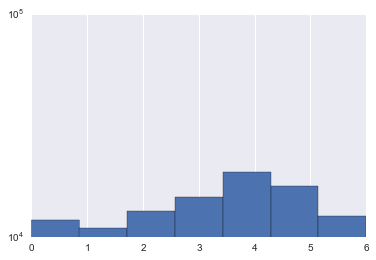

In [119]:
#df.trip_length.hist(bins=100)
fig, ax = plt.subplots()
#df[df.trip_length < 8].trip_length.hist(ax=ax, bins=6, bottom=0.1)
ax.set_yscale('log')
df[df.trip_length == 1].shape 
# only 10 trips longer than 45 days in 100000
# 500 longer than 15 days
# 5k longer than a week
# 5k exactly a week
# 88k less than 7 days
# 26k one day
df.trip_start_day.hist(bins=7)
#df.shape
df[((df.trip_start_day == 0) & (df.trip_end_day == 4))].shape 
# 3000 start monday and end thurs or friday
df['stay_workweek'].sum()

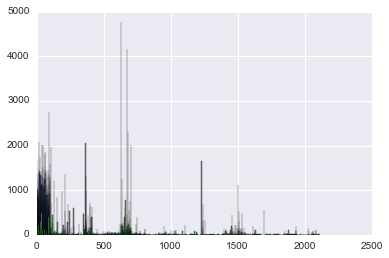

In [188]:
df.hotel_cluster.hist(bins=100)
df.hotel_cluster.value_counts()[0:10]
df.hotel_market.hist(bins=2000)

clicks = df.groupby('hotel_cluster')['hotel_cluster'].count()/100000
bookings = df[df.is_booking == 1].groupby('hotel_cluster')['hotel_cluster'].count()/df.groupby('hotel_cluster')['hotel_cluster'].count()
normal_bookings = df[((df.is_booking == 1) & (df.is_package == 0))].groupby('hotel_cluster')['hotel_cluster'].count()/df.groupby('hotel_cluster')['hotel_cluster'].count()
package_bookings = df[((df.is_booking == 1) & (df.is_package == 1))].groupby('hotel_cluster')['hotel_cluster'].count()/df.groupby('hotel_cluster')['hotel_cluster'].count()

hotels = pd.concat(
    {'clicks':clicks.astype(np.float32), 
    'bookings':bookings.astype(np.float32), 
    'normal_bookings':normal_bookings.astype(np.float32), 
    'package_bookings':package_bookings.astype(np.float32)}, axis=1)

In [ ]:
df[((df.is_booking == 1) & (df.is_package == 1))].groupby('hotel_cluster')['hotel_cluster'].count()/df.groupby('hotel_cluster')['hotel_cluster'].count()

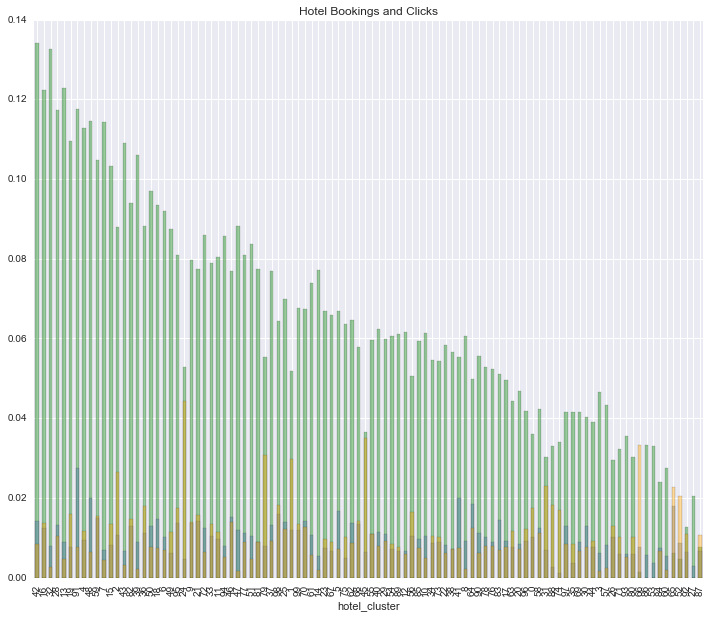

In [189]:
hotels.sort_values('bookings', ascending=False).normal_bookings.plot(kind='bar', alpha=.4, color='green', figsize=(12, 10), title='Hotel Bookings and Clicks')
hotels.sort_values('bookings', ascending=False).clicks.plot(kind='bar', alpha=.4)
hotels.sort_values('bookings', ascending=False).package_bookings.plot(kind='bar', alpha=.4, color='orange')

# popular hotels with strong package business = package_premium
# unpopular hotels with mostly packages = package_economy
# hotels with low bookings per click = disappointing

In [190]:
# merge hotel data
df = df.merge(hotels, left_on='hotel_cluster', right_index=True)


In [191]:
df.columns

Index(['Unnamed: 0', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile', 'is_package',
       'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt',
       'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id',
       'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market',
       'hotel_cluster', 'trip_start', 'trip_end', 'trip_length',
       'trip_start_day', 'trip_end_day', 'stay_long', 'stay_week', 'stay_day',
       'stay_workweek', 'bookings', 'clicks', 'normal_bookings',
       'package_bookings'],
      dtype='object')

In [256]:
df = df_users.copy()

df['loyalty'] = df['loyalty'].astype(np.float32)
df['pref_bookings'] = df['pref_bookings'].astype(np.float32)
df['pref_clicks'] = df['pref_clicks'].astype(np.float32)
df['pref_normal_bookings'] = df['pref_normal_bookings'].astype(np.float32)
df['pref_package_bookings'] = df['pref_package_bookings'].astype(np.float32)
df['trip_start_day'] = df['trip_start_day'].astype(np.float32)
df['trip_end_day'] = df['trip_end_day'].astype(np.float32)

#df.dropna
df.loc[df.pref_package_bookings.isnull(), 'pref_package_bookings'] = 0.011076

# user_location_country = 66 
# hotel_country = 50 most common
# df_train, df_test = train_test_split(df[((df.user_location_country == 66) & (df.hotel_country == 50))].sample(10000), test_size = 0.2)
# len(df_train), len(df_test)

df_train, df_test = train_test_split(df.sample(10000), test_size = 0.2)
len(df_train), len(df_test)

(8000, 2000)

In [243]:
df.pref_package_bookings.describe()

count    100000.000000
mean          0.011076
std           0.006319
min           0.001658
25%           0.007299
50%           0.009550
75%           0.013367
max           0.044304
Name: pref_package_bookings, dtype: float64

In [18]:
#[(col, dtype) for col, dtype in zip(df.columns, df.dtypes) if dtype != 'object']
num_columns = [col for col, dtype in zip(df.columns, df.dtypes) if dtype != 'object']
num_columns

['Unnamed: 0',
 'site_name',
 'posa_continent',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'orig_destination_distance',
 'user_id',
 'is_mobile',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'srch_destination_id',
 'srch_destination_type_id',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'hotel_cluster']

In [201]:
df_train.head()

,Unnamed: 0,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,...,trip_start_day,trip_end_day,stay_long,stay_week,stay_day,stay_workweek,bookings,clicks,normal_bookings,package_bookings
80683,14945574,2013-02-28 09:13:09,2,3,66,447,50736,616.7481,91892,0,...,5.0,2.0,0,0,0,0,0.073770,0.00488,0.063525,0.010246
33649,20754923,2014-04-26 23:07:16,2,3,66,447,54745,NaN,27471,0,...,4.0,5.0,0,0,1,0,0.088487,0.01051,0.083730,0.004757
71095,18932164,2014-06-24 05:50:51,2,3,66,348,26598,NaN,876466,0,...,5.0,6.0,0,0,1,0,0.029304,0.00546,0.027473,0.001832
96471,2713494,2013-10-15 21:19:39,2,3,66,174,38554,189.8264,994029,0,...,5.0,6.0,0,0,1,0,0.071429,0.00630,0.036508,0.034921
90015,31343059,2014-02-04 09:44:18,2,3,66,174,44951,0.6733,500324,0,...,1.0,6.0,0,0,0,0,0.118768,0.00682,0.114370,0.004399


In [276]:
feature_cols = ['trip_length', 'stay_long', 'stay_week', 'stay_day', 
                'srch_children_cnt','user_id','total_bookings','loyalty', 'pref_bookings',
                'pref_clicks','pref_normal_bookings','pref_package_bookings']

# feature_cols = ['trip_length', 'stay_long', 'stay_week', 'stay_day', 
#                 'srch_children_cnt','user_id','total_bookings','loyalty', 'pref_bookings',
#                 'pref_clicks','pref_normal_bookings','pref_package_bookings']


X_train = df_train[feature_cols]
y_train = df_train.hotel_cluster

X_test = df_test[feature_cols]
y_test = df_test.hotel_cluster

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
df_test['pred'] = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, df_test.pred)

0.014999999999999999

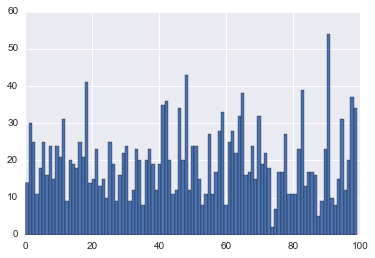

In [271]:
df_test['pred'].hist(bins=100)

In [272]:
from sklearn.metrics import classification_report
#target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(df_test.hotel_cluster, df_test['pred']))

             precision    recall  f1-score   support

          0       1.00      0.88      0.93        16
          1       0.97      0.97      0.97        30
          2       0.96      0.96      0.96        25
          3       0.91      1.00      0.95        10
          4       1.00      0.90      0.95        20
          5       0.88      0.81      0.85        27
          6       0.94      0.88      0.91        17
          7       0.92      0.96      0.94        23
          8       1.00      0.88      0.94        17
          9       0.96      0.96      0.96        24
         10       0.86      0.90      0.88        20
         11       0.81      0.96      0.88        26
         12       0.89      0.89      0.89         9
         13       0.90      0.90      0.90        20
         14       0.95      0.95      0.95        19
         15       0.94      1.00      0.97        17
         16       1.00      0.93      0.96        27
         17       1.00      0.88      0.93   

In [245]:
df_test[['hotel_cluster', 'pred']]

,hotel_cluster,pred
59321,37,37
21761,98,98
46241,28,93
30316,41,41
44763,91,91
9911,91,91
43530,0,0
84354,48,48
90850,96,24
36673,48,48


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
Unnamed: 0                   100000 non-null int64
date_time                    100000 non-null object
site_name                    100000 non-null int64
posa_continent               100000 non-null int64
user_location_country        100000 non-null int64
user_location_region         100000 non-null int64
user_location_city           100000 non-null int64
orig_destination_distance    64302 non-null float64
user_id                      100000 non-null int64
is_mobile                    100000 non-null int64
is_package                   100000 non-null int64
channel                      100000 non-null int64
srch_ci                      99865 non-null object
srch_co                      99865 non-null object
srch_adults_cnt              100000 non-null int64
srch_children_cnt            100000 non-null int64
srch_rm_cnt                  100000 non-null int64
srch_destination_id  

In [213]:
def user_analysis(group):
    total_bookings = group['user_id'].count()
    group['total_bookings'] = total_bookings.astype(np.float32)
    group['favorite_hotel'] = group.hotel_cluster.value_counts().index[0]
    times_at_favorite = group.hotel_cluster.value_counts().tolist()[0]
    if total_bookings > 2:
        group['loyalty'] = times_at_favorite / total_bookings.astype(np.float32)
    else:
        # use average loyalty for freq travelers
        group['loyalty'] = 0.19

    # preferred hotel marketing characteristics
    group['pref_bookings'] = group['bookings'].mean().astype(np.float32)
    group['pref_clicks'] = group['clicks'].mean()
    group['pref_normal_bookings'] = group['normal_bookings'].mean().astype(np.float32)
    group['pref_package_bookings'] = group['package_bookings'].mean().astype(np.float32)
        
    return group
    
df_users = df.groupby('user_id').apply(user_analysis)

In [220]:
df_users[['trip_length', 'stay_long', 'stay_week', 'stay_day', 'srch_children_cnt','user_id','total_bookings','favorite_hotel','loyalty', 'pref_bookings', 'pref_clicks', 'pref_normal_bookings', 'pref_package_bookings']]

,trip_length,stay_long,stay_week,stay_day,srch_children_cnt,user_id,total_bookings,favorite_hotel,loyalty,pref_bookings,pref_clicks,pref_normal_bookings,pref_package_bookings
0,1.0,0,0,1,0,415822,1,91,0.19,0.125182,0.027480,0.117540,0.007642
55,4.0,0,0,0,2,871424,1,91,0.19,0.125182,0.027480,0.117540,0.007642
57,3.0,0,0,0,2,183179,1,91,0.19,0.125182,0.027480,0.117540,0.007642
66,6.0,0,0,0,2,211141,2,91,0.19,0.077243,0.016470,0.072506,0.004737
85,3.0,0,0,0,1,413487,2,91,0.19,0.125182,0.027480,0.117540,0.007642
177,1.0,0,0,1,2,748620,1,91,0.19,0.125182,0.027480,0.117540,0.007642
203,1.0,0,0,1,0,653439,1,91,0.19,0.125182,0.027480,0.117540,0.007642
265,2.0,0,0,0,0,378149,2,91,0.19,0.099628,0.022110,0.092223,0.007405
292,4.0,0,0,0,0,1140606,1,91,0.19,0.125182,0.027480,0.117540,0.007642
304,1.0,0,0,1,0,735095,2,91,0.19,0.123129,0.023775,0.116069,0.007060


In [70]:
df_freq[df_freq.total_bookings > 2].sort_values(['total_bookings','user_id'], ascending=False)[['user_id', 'hotel_cluster', 'total_bookings', 'favorite_hotel', 'loyalty']].mean()

user_id           610826.211888
hotel_cluster         50.276454
total_bookings         3.200871
favorite_hotel        52.695619
loyalty                0.376377
dtype: float64

In [61]:
df[df.user_id == 873383].hotel_cluster.value_counts().tolist()[0] #[0] #.type #.tolist()

4

In [71]:
df_loyalty = pd.read_csv('data/train.csv', usecols = ['user_id',
       'hotel_market', 'hotel_cluster'], nrows=1000000).dropna()

In [94]:
df_profile = pd.read_csv('data/train.csv', usecols = ['user_id',
       'hotel_market', 'hotel_cluster', 'is_mobile', 'is_package', 
        'channel', 'srch_ci', 'srch_co', 'srch_adults_cnt', 'srch_children_cnt', 
        'srch_rm_cnt'], nrows=1000000).dropna()



In [130]:
df_profile['trip_start'] = pd.to_datetime(df['srch_ci'])
df_profile['trip_end'] = pd.to_datetime(df['srch_co'])
df_profile['trip_length'] = (df_profile.trip_end - df_profile.trip_start).astype('timedelta64[D]')

# get average trip length and replace nan, neg values and zero
#df_profile[df_profile.trip_length > 0].mean() # average is 3.4 days
df_profile.loc[((df_profile.trip_length.isnull()) | (df_profile.trip_length < 1)), 'trip_length'] = 3.4
df_profile['trip_start_day'] = df_profile.trip_start.dt.dayofweek
df_profile.trip_length.max()

240.0

In [131]:
df_cprof = df_profile.groupby('user_id').apply(user_analysis)

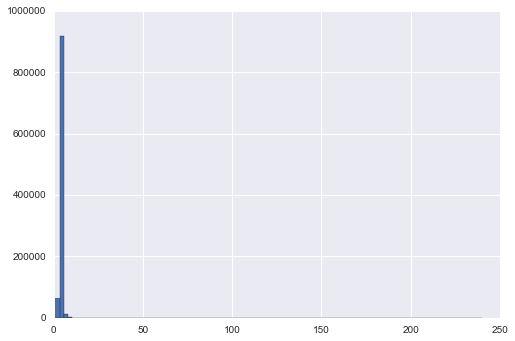

In [132]:
df_cprof.trip_length.hist(bins=100)

In [78]:
df_freq2[df_freq2.total_bookings == 2].sort_values(['total_bookings','user_id'], ascending=False)[['user_id', 'hotel_cluster', 'total_bookings', 'favorite_hotel', 'loyalty']].count()

user_id           1630
hotel_cluster     1630
total_bookings    1630
favorite_hotel    1630
loyalty           1630
dtype: int64

Index(['user_id', 'hotel_market', 'hotel_cluster', 'total_bookings',
       'favorite_hotel', 'loyalty'],
      dtype='object')

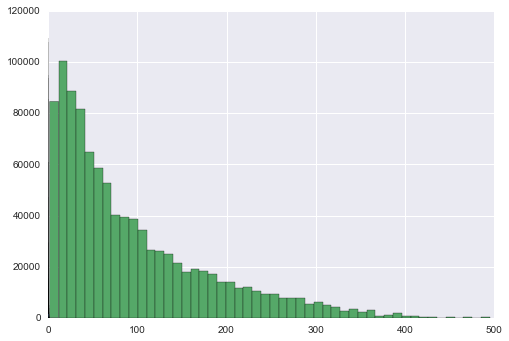

In [97]:
df_freq2.total_bookings.hist(bins=50)
df_freq2.columns

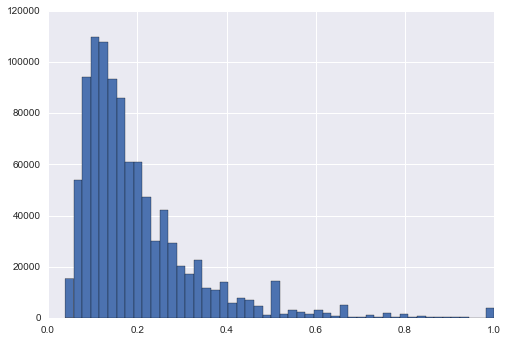

In [109]:
df_cprof.loyalty.hist(bins=50)


In [134]:
df_train, df_test = train_test_split(df_cprof, test_size = 0.2)
len(df_train), len(df_test)

(799200, 199801)

In [139]:
feature_cols = ['user_id', 'hotel_market', 'total_bookings',
       'favorite_hotel']
X_train = df_train[feature_cols]
y_train = df_train.hotel_cluster

X_test = df_test[feature_cols]
y_test = df_test.hotel_cluster

model = DecisionTreeClassifier()
model.fit(X_train, y_train)
df_test['pred'] = model.predict(X_test)

from sklearn.metrics import accuracy_score
accuracy_score(y_test, df_test.pred)

/Users/steven/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.30038888694250782

In [286]:
df_submit = pd.read_csv('data/test.csv')

In [285]:
df_submit.columns
df_submit.user_id

df_overlap = df.merge(df_submit, how='left'on='user_id')
df_overlap.shape

# test has 2.5m
# overlap is 342k
#df.shape

(100000, 45)

In [284]:
df_submit.shape

(2528243, 22)

In [ ]:
# def test_user_analysis(group):
#     user_id = group.user_id.min()
#     total_bookings = group['user_id'].count() + df_cprof[df_cprof.user_id == user_id].total_bookings.min()
#     group['total_bookings'] = total_bookings
#     group['favorite_hotel'] = df_cprof[df_cprof.user_id == user_id].favorite_hotel.min()
#     #times_at_favorite = group.hotel_cluster.value_counts().tolist()[0]
#     if total_bookings > 2:
#         group['loyalty'] = df_cprof[df_cprof.user_id == user_id].loyalty.min()
#     else:
#         # use average loyalty for freq travelers
#         group['loyalty'] = 0.19
#     return group


# df_submit = df_submit.groupby('user_id').apply(test_user_analysis)

df_submit = df_submit.merge(df_cprof[['user_id', 'favorite_hotel', 'total_bookings', 'loyalty']], on='user_id')


In [152]:
df_submit.columns

Index(['id', 'date_time', 'site_name', 'posa_continent',
       'user_location_country', 'user_location_region', 'user_location_city',
       'orig_destination_distance', 'user_id', 'is_mobile_x', 'is_package_x',
       'channel_x', 'srch_ci_x', 'srch_co_x', 'srch_adults_cnt_x',
       'srch_children_cnt_x', 'srch_rm_cnt_x', 'srch_destination_id',
       'srch_destination_type_id', 'hotel_continent', 'hotel_country',
       'hotel_market_x', 'is_mobile_y', 'is_package_y', 'channel_y',
       'srch_ci_y', 'srch_co_y', 'srch_adults_cnt_y', 'srch_children_cnt_y',
       'srch_rm_cnt_y', 'hotel_market_y', 'hotel_cluster', 'trip_days',
       'trip_start', 'trip_end', 'trip_length', 'trip_start_day',
       'total_bookings', 'favorite_hotel', 'loyalty'],
      dtype='object')

In [153]:
df_submit['trip_start'] = pd.to_datetime(df['srch_ci'])
df_submit['trip_end'] = pd.to_datetime(df['srch_co'])
df_submit['trip_length'] = (df_submit.trip_end - df_submit.trip_start).astype('timedelta64[D]')

# get average trip length and replace nan, neg values and zero
#df_profile[df_profile.trip_length > 0].mean() # average is 3.4 days
df_submit.loc[((df_submit.trip_length.isnull()) | (df_submit.trip_length < 1)), 'trip_length'] = 3.4
df_submit['trip_start_day'] = df_submit.trip_start.dt.dayofweek
df_submit.trip_length.max()

240.0

In [155]:
df_submit['hotel_market'] = df_submit['hotel_market_x']
Xsub_test = df_submit[feature_cols]

In [156]:
df_submit['pred'] = model.predict(Xsub_test)


In [1]:
df_submit[['id', 'pred']].shape

NameError: name 'df_submit' is not defined